In [1]:
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/home/user/workdir/main/src/'))))
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/user/.local/lib/python3.10/site-packages',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages']

In [4]:
# Import
import os
from PIL import Image

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# Training (Nitrate)

In [22]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/related_nitrate_PM25_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :68], ctrl_data[:, 68]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [25]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/nitrate/modified/pm25/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*4,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch < 1000: return 1e-3
    else: return 5e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Epoch 1/1000
INFO:tensorflow:Collective all_reduce tensors: 84 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 84 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 84 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 84 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


3/3 [==============================] - ETA: 0s - loss: 25.5551 INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-01-29.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-01-29.80/assets


3/3 [==============================] - 41s 6s/step - loss: 25.5551 - val_loss: 29.8036 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 21.5349INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-02-29.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-02-29.63/assets


3/3 [==============================] - 8s 4s/step - loss: 21.5349 - val_loss: 29.6269 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 18.2488INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-03-29.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-03-29.26/assets


3/3 [==============================] - 8s 4s/step - loss: 18.2488 - val_loss: 29.2561 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 16.1245INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-04-28.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-04-28.72/assets


3/3 [==============================] - 17s 8s/step - loss: 16.1245 - val_loss: 28.7214 - lr: 0.0010
Epoch 5/1000
2/3 [===================>..........] - ETA: 0s - loss: 14.5222INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-05-28.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-05-28.03/assets


3/3 [==============================] - 8s 4s/step - loss: 14.4726 - val_loss: 28.0347 - lr: 0.0010
Epoch 6/1000
2/3 [===================>..........] - ETA: 0s - loss: 13.2326INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-06-27.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-06-27.19/assets


3/3 [==============================] - 8s 4s/step - loss: 13.1862 - val_loss: 27.1869 - lr: 0.0010
Epoch 7/1000
2/3 [===================>..........] - ETA: 0s - loss: 12.3125INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-07-26.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-07-26.21/assets


3/3 [==============================] - 8s 4s/step - loss: 12.3115 - val_loss: 26.2116 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - ETA: 0s - loss: 11.6867INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-08-25.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-08-25.16/assets


3/3 [==============================] - 8s 4s/step - loss: 11.6867 - val_loss: 25.1578 - lr: 0.0010
Epoch 9/1000
2/3 [===================>..........] - ETA: 0s - loss: 11.2711INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-09-24.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-09-24.04/assets


3/3 [==============================] - 8s 4s/step - loss: 11.2325 - val_loss: 24.0399 - lr: 0.0010
Epoch 10/1000
3/3 [==============================] - ETA: 0s - loss: 10.8610INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-10-22.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-10-22.94/assets


3/3 [==============================] - 8s 4s/step - loss: 10.8610 - val_loss: 22.9406 - lr: 0.0010
Epoch 11/1000
3/3 [==============================] - ETA: 0s - loss: 10.5529INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-11-21.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-11-21.88/assets


3/3 [==============================] - 18s 9s/step - loss: 10.5529 - val_loss: 21.8841 - lr: 0.0010
Epoch 12/1000
3/3 [==============================] - ETA: 0s - loss: 10.2715INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-12-20.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-12-20.89/assets


3/3 [==============================] - 9s 4s/step - loss: 10.2715 - val_loss: 20.8926 - lr: 0.0010
Epoch 13/1000
2/3 [===================>..........] - ETA: 0s - loss: 10.0117INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-13-19.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-13-19.96/assets


3/3 [==============================] - 8s 4s/step - loss: 10.0190 - val_loss: 19.9552 - lr: 0.0010
Epoch 14/1000
3/3 [==============================] - ETA: 0s - loss: 9.7839INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-14-19.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-14-19.07/assets


3/3 [==============================] - 9s 4s/step - loss: 9.7839 - val_loss: 19.0744 - lr: 0.0010
Epoch 15/1000
3/3 [==============================] - ETA: 0s - loss: 9.5572INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-15-18.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-15-18.25/assets


3/3 [==============================] - 8s 4s/step - loss: 9.5572 - val_loss: 18.2474 - lr: 0.0010
Epoch 16/1000
3/3 [==============================] - ETA: 0s - loss: 9.3411INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-16-17.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-16-17.54/assets


3/3 [==============================] - 8s 4s/step - loss: 9.3411 - val_loss: 17.5380 - lr: 0.0010
Epoch 17/1000
3/3 [==============================] - ETA: 0s - loss: 9.1269INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-17-16.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-17-16.86/assets


3/3 [==============================] - 8s 4s/step - loss: 9.1269 - val_loss: 16.8627 - lr: 0.0010
Epoch 18/1000
3/3 [==============================] - ETA: 0s - loss: 8.9224INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-18-16.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-18-16.28/assets


3/3 [==============================] - 8s 4s/step - loss: 8.9224 - val_loss: 16.2835 - lr: 0.0010
Epoch 19/1000
3/3 [==============================] - ETA: 0s - loss: 8.7207INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-19-15.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-19-15.69/assets


3/3 [==============================] - 19s 10s/step - loss: 8.7207 - val_loss: 15.6944 - lr: 0.0010
Epoch 20/1000
3/3 [==============================] - ETA: 0s - loss: 8.5187INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-20-15.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-20-15.17/assets


3/3 [==============================] - 9s 4s/step - loss: 8.5187 - val_loss: 15.1675 - lr: 0.0010
Epoch 21/1000
3/3 [==============================] - ETA: 0s - loss: 8.3112INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-21-14.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-21-14.73/assets


3/3 [==============================] - 9s 4s/step - loss: 8.3112 - val_loss: 14.7257 - lr: 0.0010
Epoch 22/1000
3/3 [==============================] - ETA: 0s - loss: 8.0866INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-22-14.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-22-14.45/assets


3/3 [==============================] - 9s 4s/step - loss: 8.0866 - val_loss: 14.4537 - lr: 0.0010
Epoch 23/1000
2/3 [===================>..........] - ETA: 0s - loss: 7.8494INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-23-14.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-23-14.26/assets


3/3 [==============================] - 9s 4s/step - loss: 7.8204 - val_loss: 14.2607 - lr: 0.0010
Epoch 24/1000
3/3 [==============================] - ETA: 0s - loss: 7.6020INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-24-13.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-24-13.91/assets


3/3 [==============================] - 9s 4s/step - loss: 7.6020 - val_loss: 13.9122 - lr: 0.0010
Epoch 25/1000
2/3 [===================>..........] - ETA: 0s - loss: 7.3613INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-25-13.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-25-13.49/assets


3/3 [==============================] - 8s 4s/step - loss: 7.3630 - val_loss: 13.4908 - lr: 0.0010
Epoch 26/1000
3/3 [==============================] - ETA: 0s - loss: 7.1499INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-26-13.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-26-13.29/assets


3/3 [==============================] - 19s 10s/step - loss: 7.1499 - val_loss: 13.2934 - lr: 0.0010
Epoch 27/1000
2/3 [===================>..........] - ETA: 0s - loss: 6.9764INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-27-13.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-27-13.03/assets


3/3 [==============================] - 9s 4s/step - loss: 6.9410 - val_loss: 13.0350 - lr: 0.0010
Epoch 28/1000
3/3 [==============================] - ETA: 0s - loss: 6.7470INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-28-12.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-28-12.56/assets


3/3 [==============================] - 9s 4s/step - loss: 6.7470 - val_loss: 12.5565 - lr: 0.0010
Epoch 29/1000
3/3 [==============================] - ETA: 0s - loss: 6.5596INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-29-12.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-29-12.07/assets


3/3 [==============================] - 9s 4s/step - loss: 6.5596 - val_loss: 12.0737 - lr: 0.0010
Epoch 30/1000
2/3 [===================>..........] - ETA: 0s - loss: 6.3974INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-30-11.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-30-11.81/assets


3/3 [==============================] - 9s 4s/step - loss: 6.3779 - val_loss: 11.8066 - lr: 0.0010
Epoch 31/1000
3/3 [==============================] - ETA: 0s - loss: 6.2070INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-31-11.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-31-11.50/assets


3/3 [==============================] - 8s 4s/step - loss: 6.2070 - val_loss: 11.4959 - lr: 0.0010
Epoch 32/1000
3/3 [==============================] - ETA: 0s - loss: 6.0395INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-32-11.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-32-11.13/assets


3/3 [==============================] - 9s 4s/step - loss: 6.0395 - val_loss: 11.1284 - lr: 0.0010
Epoch 33/1000
3/3 [==============================] - ETA: 0s - loss: 5.8752INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-33-10.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-33-10.80/assets


3/3 [==============================] - 8s 4s/step - loss: 5.8752 - val_loss: 10.8040 - lr: 0.0010
Epoch 34/1000
3/3 [==============================] - ETA: 0s - loss: 5.7194INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-34-10.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-34-10.59/assets


3/3 [==============================] - 20s 10s/step - loss: 5.7194 - val_loss: 10.5866 - lr: 0.0010
Epoch 35/1000
3/3 [==============================] - ETA: 0s - loss: 5.5652INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-35-10.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-35-10.38/assets


3/3 [==============================] - 9s 4s/step - loss: 5.5652 - val_loss: 10.3850 - lr: 0.0010
Epoch 36/1000
3/3 [==============================] - ETA: 0s - loss: 5.4133INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-36-10.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-36-10.18/assets


3/3 [==============================] - 9s 4s/step - loss: 5.4133 - val_loss: 10.1845 - lr: 0.0010
Epoch 37/1000
3/3 [==============================] - ETA: 0s - loss: 5.2688INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-37-9.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-37-9.98/assets


3/3 [==============================] - 9s 4s/step - loss: 5.2688 - val_loss: 9.9780 - lr: 0.0010
Epoch 38/1000
3/3 [==============================] - ETA: 0s - loss: 5.1271INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-38-9.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-38-9.79/assets


3/3 [==============================] - 9s 4s/step - loss: 5.1271 - val_loss: 9.7939 - lr: 0.0010
Epoch 39/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.9770INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-39-9.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-39-9.67/assets


3/3 [==============================] - 9s 4s/step - loss: 4.9854 - val_loss: 9.6660 - lr: 0.0010
Epoch 40/1000
3/3 [==============================] - ETA: 0s - loss: 4.8492INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-40-9.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-40-9.53/assets


3/3 [==============================] - 8s 4s/step - loss: 4.8492 - val_loss: 9.5337 - lr: 0.0010
Epoch 41/1000
3/3 [==============================] - ETA: 0s - loss: 4.7153INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-41-9.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-41-9.40/assets


3/3 [==============================] - 8s 4s/step - loss: 4.7153 - val_loss: 9.4009 - lr: 0.0010
Epoch 42/1000
3/3 [==============================] - ETA: 0s - loss: 4.5873INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-42-9.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-42-9.25/assets


3/3 [==============================] - 20s 10s/step - loss: 4.5873 - val_loss: 9.2542 - lr: 0.0010
Epoch 43/1000
3/3 [==============================] - ETA: 0s - loss: 4.4602INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-43-9.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-43-9.10/assets


3/3 [==============================] - 9s 5s/step - loss: 4.4602 - val_loss: 9.0978 - lr: 0.0010
Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 4.3363INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-44-9.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-44-9.01/assets


3/3 [==============================] - 9s 4s/step - loss: 4.3363 - val_loss: 9.0141 - lr: 0.0010
Epoch 45/1000
3/3 [==============================] - ETA: 0s - loss: 4.2162INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-45-8.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-45-8.87/assets


3/3 [==============================] - 9s 4s/step - loss: 4.2162 - val_loss: 8.8682 - lr: 0.0010
Epoch 46/1000
3/3 [==============================] - ETA: 0s - loss: 4.0897INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-46-8.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-46-8.78/assets


3/3 [==============================] - 9s 4s/step - loss: 4.0897 - val_loss: 8.7809 - lr: 0.0010
Epoch 47/1000
3/3 [==============================] - ETA: 0s - loss: 3.9718INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-47-8.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-47-8.70/assets


3/3 [==============================] - 9s 4s/step - loss: 3.9718 - val_loss: 8.6972 - lr: 0.0010
Epoch 48/1000
3/3 [==============================] - ETA: 0s - loss: 3.8605INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-48-8.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-48-8.62/assets


3/3 [==============================] - 8s 4s/step - loss: 3.8605 - val_loss: 8.6224 - lr: 0.0010
Epoch 49/1000
3/3 [==============================] - ETA: 0s - loss: 3.7459INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-49-8.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-49-8.59/assets


3/3 [==============================] - 8s 4s/step - loss: 3.7459 - val_loss: 8.5911 - lr: 0.0010
Epoch 50/1000
3/3 [==============================] - ETA: 0s - loss: 3.6445INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-50-8.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-50-8.42/assets


3/3 [==============================] - 20s 10s/step - loss: 3.6445 - val_loss: 8.4207 - lr: 0.0010
Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 3.5355INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-51-8.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-51-8.41/assets


3/3 [==============================] - 9s 4s/step - loss: 3.5355 - val_loss: 8.4075 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 3.4324INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-52-8.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-52-8.22/assets


3/3 [==============================] - 9s 4s/step - loss: 3.4324 - val_loss: 8.2153 - lr: 0.0010
Epoch 53/1000
3/3 [==============================] - ETA: 0s - loss: 3.3400INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-53-8.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-53-8.16/assets


3/3 [==============================] - 9s 4s/step - loss: 3.3400 - val_loss: 8.1557 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 3.2397INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-54-8.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-54-8.06/assets


3/3 [==============================] - 9s 4s/step - loss: 3.2397 - val_loss: 8.0589 - lr: 0.0010
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 3.1399INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-55-7.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-55-7.93/assets


3/3 [==============================] - 9s 4s/step - loss: 3.1399 - val_loss: 7.9331 - lr: 0.0010
Epoch 56/1000
3/3 [==============================] - ETA: 0s - loss: 3.0530INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-56-7.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-56-7.92/assets


3/3 [==============================] - 8s 4s/step - loss: 3.0530 - val_loss: 7.9219 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 2.9630INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-57-7.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-57-7.78/assets


3/3 [==============================] - 8s 4s/step - loss: 2.9630 - val_loss: 7.7754 - lr: 0.0010
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 2.8712INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-58-7.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-58-7.64/assets


3/3 [==============================] - 21s 10s/step - loss: 2.8712 - val_loss: 7.6416 - lr: 0.0010
Epoch 59/1000
3/3 [==============================] - 1s 244ms/step - loss: 2.7857 - val_loss: 7.6469 - lr: 0.0010
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 2.7048INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-60-7.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-60-7.55/assets


3/3 [==============================] - 9s 4s/step - loss: 2.7048 - val_loss: 7.5520 - lr: 0.0010
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 2.6297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-61-7.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-61-7.46/assets


3/3 [==============================] - 9s 4s/step - loss: 2.6297 - val_loss: 7.4557 - lr: 0.0010
Epoch 62/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.5366INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-62-7.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-62-7.35/assets


3/3 [==============================] - 9s 4s/step - loss: 2.5527 - val_loss: 7.3484 - lr: 0.0010
Epoch 63/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.4869INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-63-7.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-63-7.22/assets


3/3 [==============================] - 9s 4s/step - loss: 2.4802 - val_loss: 7.2223 - lr: 0.0010
Epoch 64/1000
3/3 [==============================] - ETA: 0s - loss: 2.4075INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-64-7.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-64-7.22/assets


3/3 [==============================] - 9s 4s/step - loss: 2.4075 - val_loss: 7.2213 - lr: 0.0010
Epoch 65/1000
3/3 [==============================] - 0s 207ms/step - loss: 2.3307 - val_loss: 7.2353 - lr: 0.0010
Epoch 66/1000
3/3 [==============================] - ETA: 0s - loss: 2.2639INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-66-7.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-66-7.09/assets


3/3 [==============================] - 9s 4s/step - loss: 2.2639 - val_loss: 7.0874 - lr: 0.0010
Epoch 67/1000
3/3 [==============================] - ETA: 0s - loss: 2.1959INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-67-6.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-67-6.98/assets


3/3 [==============================] - 8s 4s/step - loss: 2.1959 - val_loss: 6.9814 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 2.1294INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-68-6.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-68-6.78/assets


3/3 [==============================] - 21s 10s/step - loss: 2.1294 - val_loss: 6.7829 - lr: 0.0010
Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 2.0689INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-69-6.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-69-6.73/assets


3/3 [==============================] - 9s 4s/step - loss: 2.0689 - val_loss: 6.7251 - lr: 0.0010
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 2.0072INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-70-6.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-70-6.65/assets


3/3 [==============================] - 9s 5s/step - loss: 2.0072 - val_loss: 6.6528 - lr: 0.0010
Epoch 71/1000
3/3 [==============================] - ETA: 0s - loss: 1.9511INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-71-6.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-71-6.62/assets


3/3 [==============================] - 9s 4s/step - loss: 1.9511 - val_loss: 6.6197 - lr: 0.0010
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 1.8955INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-72-6.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-72-6.53/assets


3/3 [==============================] - 9s 4s/step - loss: 1.8955 - val_loss: 6.5281 - lr: 0.0010
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 1.8446INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-73-6.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-73-6.41/assets


3/3 [==============================] - 9s 4s/step - loss: 1.8446 - val_loss: 6.4094 - lr: 0.0010
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 1.8010INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-74-6.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-74-6.14/assets


3/3 [==============================] - 8s 4s/step - loss: 1.8010 - val_loss: 6.1377 - lr: 0.0010
Epoch 75/1000
3/3 [==============================] - ETA: 0s - loss: 1.7439INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-75-5.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-75-5.94/assets


3/3 [==============================] - 9s 4s/step - loss: 1.7439 - val_loss: 5.9395 - lr: 0.0010
Epoch 76/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.6899INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-76-5.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-76-5.83/assets


3/3 [==============================] - 21s 10s/step - loss: 1.6891 - val_loss: 5.8316 - lr: 0.0010
Epoch 77/1000
3/3 [==============================] - ETA: 0s - loss: 1.6497INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-77-5.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-77-5.71/assets


3/3 [==============================] - 9s 4s/step - loss: 1.6497 - val_loss: 5.7133 - lr: 0.0010
Epoch 78/1000
3/3 [==============================] - ETA: 0s - loss: 1.6028INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-78-5.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-78-5.68/assets


3/3 [==============================] - 9s 5s/step - loss: 1.6028 - val_loss: 5.6768 - lr: 0.0010
Epoch 79/1000
3/3 [==============================] - ETA: 0s - loss: 1.5555INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-79-5.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-79-5.53/assets


3/3 [==============================] - 9s 4s/step - loss: 1.5555 - val_loss: 5.5349 - lr: 0.0010
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 1.5092INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-80-5.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-80-5.45/assets


3/3 [==============================] - 9s 4s/step - loss: 1.5092 - val_loss: 5.4450 - lr: 0.0010
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 1.4667INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-81-5.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-81-5.41/assets


3/3 [==============================] - 9s 4s/step - loss: 1.4667 - val_loss: 5.4148 - lr: 0.0010
Epoch 82/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4186INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-82-5.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-82-5.33/assets


3/3 [==============================] - 8s 4s/step - loss: 1.4209 - val_loss: 5.3315 - lr: 0.0010
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 1.3796INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-83-5.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-83-5.22/assets


3/3 [==============================] - 8s 4s/step - loss: 1.3796 - val_loss: 5.2156 - lr: 0.0010
Epoch 84/1000
3/3 [==============================] - ETA: 0s - loss: 1.3416INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-84-5.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-84-5.18/assets


3/3 [==============================] - 21s 11s/step - loss: 1.3416 - val_loss: 5.1811 - lr: 0.0010
Epoch 85/1000
3/3 [==============================] - 1s 233ms/step - loss: 1.3034 - val_loss: 5.2514 - lr: 0.0010
Epoch 86/1000
3/3 [==============================] - ETA: 0s - loss: 1.2683INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-86-5.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-86-5.04/assets


3/3 [==============================] - 9s 5s/step - loss: 1.2683 - val_loss: 5.0401 - lr: 0.0010
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 1.2347INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-87-5.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-87-5.01/assets


3/3 [==============================] - 9s 4s/step - loss: 1.2347 - val_loss: 5.0058 - lr: 0.0010
Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 1.1996INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-88-4.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-88-4.91/assets


3/3 [==============================] - 9s 4s/step - loss: 1.1996 - val_loss: 4.9112 - lr: 0.0010
Epoch 89/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1669INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-89-4.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-89-4.74/assets


3/3 [==============================] - 9s 4s/step - loss: 1.1681 - val_loss: 4.7430 - lr: 0.0010
Epoch 90/1000
3/3 [==============================] - ETA: 0s - loss: 1.1344INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-90-4.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-90-4.67/assets


3/3 [==============================] - 9s 4s/step - loss: 1.1344 - val_loss: 4.6664 - lr: 0.0010
Epoch 91/1000
3/3 [==============================] - ETA: 0s - loss: 1.1012INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-91-4.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-91-4.63/assets


3/3 [==============================] - 9s 4s/step - loss: 1.1012 - val_loss: 4.6342 - lr: 0.0010
Epoch 92/1000
3/3 [==============================] - ETA: 0s - loss: 1.0735INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-92-4.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-92-4.48/assets


3/3 [==============================] - 8s 4s/step - loss: 1.0735 - val_loss: 4.4767 - lr: 0.0010
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 1.0479INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-93-4.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-93-4.33/assets


3/3 [==============================] - 8s 4s/step - loss: 1.0479 - val_loss: 4.3271 - lr: 0.0010
Epoch 94/1000
3/3 [==============================] - 0s 204ms/step - loss: 1.0181 - val_loss: 4.4036 - lr: 0.0010
Epoch 95/1000
3/3 [==============================] - ETA: 0s - loss: 0.9971INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-95-4.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-95-4.22/assets


3/3 [==============================] - 22s 11s/step - loss: 0.9971 - val_loss: 4.2190 - lr: 0.0010
Epoch 96/1000
3/3 [==============================] - ETA: 0s - loss: 0.9765INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-96-3.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-96-3.98/assets


3/3 [==============================] - 9s 4s/step - loss: 0.9765 - val_loss: 3.9841 - lr: 0.0010
Epoch 97/1000
3/3 [==============================] - ETA: 0s - loss: 0.9378INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-97-3.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-97-3.86/assets


3/3 [==============================] - 9s 4s/step - loss: 0.9378 - val_loss: 3.8643 - lr: 0.0010
Epoch 98/1000
3/3 [==============================] - ETA: 0s - loss: 0.9103INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-98-3.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-98-3.73/assets


3/3 [==============================] - 9s 4s/step - loss: 0.9103 - val_loss: 3.7272 - lr: 0.0010
Epoch 99/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8823INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-99-3.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-99-3.61/assets


3/3 [==============================] - 9s 4s/step - loss: 0.8862 - val_loss: 3.6148 - lr: 0.0010
Epoch 100/1000
3/3 [==============================] - ETA: 0s - loss: 0.8626INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-100-3.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-100-3.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.8626 - val_loss: 3.5256 - lr: 0.0010
Epoch 101/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.8379 - val_loss: 3.5446 - lr: 0.0010
Epoch 102/1000
3/3 [==============================] - ETA: 0s - loss: 0.8188INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-102-3.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-102-3.32/assets


3/3 [==============================] - 9s 4s/step - loss: 0.8188 - val_loss: 3.3216 - lr: 0.0010
Epoch 103/1000
3/3 [==============================] - ETA: 0s - loss: 0.7929INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-103-3.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-103-3.25/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7929 - val_loss: 3.2454 - lr: 0.0010
Epoch 104/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7733INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-104-3.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-104-3.17/assets


3/3 [==============================] - 22s 11s/step - loss: 0.7700 - val_loss: 3.1668 - lr: 0.0010
Epoch 105/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7452INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-105-3.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-105-3.11/assets


3/3 [==============================] - 9s 5s/step - loss: 0.7460 - val_loss: 3.1136 - lr: 0.0010
Epoch 106/1000
3/3 [==============================] - ETA: 0s - loss: 0.7260INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-106-3.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-106-3.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7260 - val_loss: 3.0844 - lr: 0.0010
Epoch 107/1000
3/3 [==============================] - ETA: 0s - loss: 0.7072INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-107-2.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-107-2.93/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7072 - val_loss: 2.9260 - lr: 0.0010
Epoch 108/1000
3/3 [==============================] - ETA: 0s - loss: 0.6864INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-108-2.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-108-2.85/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6864 - val_loss: 2.8511 - lr: 0.0010
Epoch 109/1000
3/3 [==============================] - ETA: 0s - loss: 0.6695INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-109-2.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-109-2.76/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6695 - val_loss: 2.7598 - lr: 0.0010
Epoch 110/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.6478INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-110-2.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-110-2.64/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6489 - val_loss: 2.6365 - lr: 0.0010
Epoch 111/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.6284INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-111-2.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-111-2.56/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6299 - val_loss: 2.5561 - lr: 0.0010
Epoch 112/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.6133INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-112-2.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-112-2.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6134 - val_loss: 2.5273 - lr: 0.0010
Epoch 113/1000
3/3 [==============================] - ETA: 0s - loss: 0.5952INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-113-2.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-113-2.41/assets


3/3 [==============================] - 23s 11s/step - loss: 0.5952 - val_loss: 2.4050 - lr: 0.0010
Epoch 114/1000
3/3 [==============================] - ETA: 0s - loss: 0.5794INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-114-2.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-114-2.37/assets


3/3 [==============================] - 9s 5s/step - loss: 0.5794 - val_loss: 2.3681 - lr: 0.0010
Epoch 115/1000
3/3 [==============================] - ETA: 0s - loss: 0.5651INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-115-2.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-115-2.26/assets


3/3 [==============================] - 9s 5s/step - loss: 0.5651 - val_loss: 2.2614 - lr: 0.0010
Epoch 116/1000
3/3 [==============================] - ETA: 0s - loss: 0.5512INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-116-2.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-116-2.21/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5512 - val_loss: 2.2054 - lr: 0.0010
Epoch 117/1000
3/3 [==============================] - ETA: 0s - loss: 0.5351INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-117-2.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-117-2.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5351 - val_loss: 2.0810 - lr: 0.0010
Epoch 118/1000
3/3 [==============================] - ETA: 0s - loss: 0.5197INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-118-2.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-118-2.00/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5197 - val_loss: 2.0003 - lr: 0.0010
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 0.5057INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-119-1.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-119-1.95/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5057 - val_loss: 1.9487 - lr: 0.0010
Epoch 120/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.4927INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-120-1.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-120-1.87/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4903 - val_loss: 1.8667 - lr: 0.0010
Epoch 121/1000
3/3 [==============================] - ETA: 0s - loss: 0.4768INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-121-1.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-121-1.83/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4768 - val_loss: 1.8250 - lr: 0.0010
Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.4613INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-122-1.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-122-1.80/assets


3/3 [==============================] - 22s 11s/step - loss: 0.4613 - val_loss: 1.7983 - lr: 0.0010
Epoch 123/1000
3/3 [==============================] - ETA: 0s - loss: 0.4489INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-123-1.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-123-1.76/assets


3/3 [==============================] - 9s 5s/step - loss: 0.4489 - val_loss: 1.7596 - lr: 0.0010
Epoch 124/1000
3/3 [==============================] - ETA: 0s - loss: 0.4369INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-124-1.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-124-1.65/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4369 - val_loss: 1.6472 - lr: 0.0010
Epoch 125/1000
3/3 [==============================] - ETA: 0s - loss: 0.4278INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-125-1.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-125-1.55/assets


3/3 [==============================] - 9s 5s/step - loss: 0.4278 - val_loss: 1.5524 - lr: 0.0010
Epoch 126/1000
3/3 [==============================] - ETA: 0s - loss: 0.4213INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-126-1.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-126-1.48/assets


3/3 [==============================] - 9s 5s/step - loss: 0.4213 - val_loss: 1.4823 - lr: 0.0010
Epoch 127/1000
3/3 [==============================] - ETA: 0s - loss: 0.4023INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-127-1.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-127-1.41/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4023 - val_loss: 1.4107 - lr: 0.0010
Epoch 128/1000
3/3 [==============================] - ETA: 0s - loss: 0.3901INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-128-1.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-128-1.35/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3901 - val_loss: 1.3549 - lr: 0.0010
Epoch 129/1000
3/3 [==============================] - ETA: 0s - loss: 0.3777INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-129-1.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-129-1.31/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3777 - val_loss: 1.3130 - lr: 0.0010
Epoch 130/1000
3/3 [==============================] - ETA: 0s - loss: 0.3673INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-130-1.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-130-1.28/assets


3/3 [==============================] - 22s 11s/step - loss: 0.3673 - val_loss: 1.2793 - lr: 0.0010
Epoch 131/1000
3/3 [==============================] - ETA: 0s - loss: 0.3593INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-131-1.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-131-1.23/assets


3/3 [==============================] - 10s 5s/step - loss: 0.3593 - val_loss: 1.2305 - lr: 0.0010
Epoch 132/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.3520INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-132-1.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-132-1.22/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3511 - val_loss: 1.2151 - lr: 0.0010
Epoch 133/1000
3/3 [==============================] - ETA: 0s - loss: 0.3403INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-133-1.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-133-1.17/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3403 - val_loss: 1.1666 - lr: 0.0010
Epoch 134/1000
3/3 [==============================] - ETA: 0s - loss: 0.3290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-134-1.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-134-1.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3290 - val_loss: 1.1042 - lr: 0.0010
Epoch 135/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.3248 - val_loss: 1.1043 - lr: 0.0010
Epoch 136/1000
3/3 [==============================] - ETA: 0s - loss: 0.3136INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-136-1.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-136-1.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3136 - val_loss: 1.0335 - lr: 0.0010
Epoch 137/1000
3/3 [==============================] - ETA: 0s - loss: 0.3023INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-137-0.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-137-0.99/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3023 - val_loss: 0.9933 - lr: 0.0010
Epoch 138/1000
3/3 [==============================] - ETA: 0s - loss: 0.2943INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-138-0.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-138-0.91/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2943 - val_loss: 0.9058 - lr: 0.0010
Epoch 139/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.2858 - val_loss: 0.9089 - lr: 0.0010
Epoch 140/1000
3/3 [==============================] - ETA: 0s - loss: 0.2778INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-140-0.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-140-0.89/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2778 - val_loss: 0.8870 - lr: 0.0010
Epoch 141/1000
3/3 [==============================] - ETA: 0s - loss: 0.2727INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-141-0.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-141-0.85/assets


3/3 [==============================] - 22s 11s/step - loss: 0.2727 - val_loss: 0.8481 - lr: 0.0010
Epoch 142/1000
3/3 [==============================] - ETA: 0s - loss: 0.2681INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-142-0.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-142-0.79/assets


3/3 [==============================] - 9s 5s/step - loss: 0.2681 - val_loss: 0.7917 - lr: 0.0010
Epoch 143/1000
3/3 [==============================] - 1s 236ms/step - loss: 0.2568 - val_loss: 0.8049 - lr: 0.0010
Epoch 144/1000
3/3 [==============================] - ETA: 0s - loss: 0.2548INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-144-0.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-144-0.75/assets


3/3 [==============================] - 9s 5s/step - loss: 0.2548 - val_loss: 0.7502 - lr: 0.0010
Epoch 145/1000
3/3 [==============================] - ETA: 0s - loss: 0.2447INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-145-0.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-145-0.72/assets


3/3 [==============================] - 9s 5s/step - loss: 0.2447 - val_loss: 0.7236 - lr: 0.0010
Epoch 146/1000
3/3 [==============================] - ETA: 0s - loss: 0.2368INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-146-0.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-146-0.67/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2368 - val_loss: 0.6655 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - ETA: 0s - loss: 0.2286INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-147-0.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-147-0.65/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2286 - val_loss: 0.6549 - lr: 0.0010
Epoch 148/1000
3/3 [==============================] - ETA: 0s - loss: 0.2231INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-148-0.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-148-0.63/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2231 - val_loss: 0.6276 - lr: 0.0010
Epoch 149/1000
3/3 [==============================] - ETA: 0s - loss: 0.2185INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-149-0.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-149-0.59/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2185 - val_loss: 0.5894 - lr: 0.0010
Epoch 150/1000
3/3 [==============================] - ETA: 0s - loss: 0.2155INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-150-0.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-150-0.58/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2155 - val_loss: 0.5849 - lr: 0.0010
Epoch 151/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.2084 - val_loss: 0.5860 - lr: 0.0010
Epoch 152/1000
3/3 [==============================] - ETA: 0s - loss: 0.2030INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-152-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-152-0.53/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2030 - val_loss: 0.5275 - lr: 0.0010
Epoch 153/1000
3/3 [==============================] - ETA: 0s - loss: 0.1964INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-153-0.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-153-0.49/assets


3/3 [==============================] - 23s 12s/step - loss: 0.1964 - val_loss: 0.4893 - lr: 0.0010
Epoch 154/1000
3/3 [==============================] - ETA: 0s - loss: 0.1931INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-154-0.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-154-0.46/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1931 - val_loss: 0.4607 - lr: 0.0010
Epoch 155/1000
3/3 [==============================] - ETA: 0s - loss: 0.1869INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-155-0.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-155-0.46/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1869 - val_loss: 0.4578 - lr: 0.0010
Epoch 156/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1818INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-156-0.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-156-0.45/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1811 - val_loss: 0.4503 - lr: 0.0010
Epoch 157/1000
3/3 [==============================] - ETA: 0s - loss: 0.1769INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-157-0.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-157-0.43/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1769 - val_loss: 0.4263 - lr: 0.0010
Epoch 158/1000
3/3 [==============================] - ETA: 0s - loss: 0.1728INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-158-0.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-158-0.43/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1728 - val_loss: 0.4252 - lr: 0.0010
Epoch 159/1000
3/3 [==============================] - ETA: 0s - loss: 0.1701INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-159-0.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-159-0.40/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1701 - val_loss: 0.3985 - lr: 0.0010
Epoch 160/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.1648 - val_loss: 0.4008 - lr: 0.0010
Epoch 161/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1618INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-161-0.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-161-0.37/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1611 - val_loss: 0.3739 - lr: 0.0010
Epoch 162/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.1579 - val_loss: 0.3750 - lr: 0.0010
Epoch 163/1000
3/3 [==============================] - ETA: 0s - loss: 0.1524INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-163-0.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-163-0.34/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1524 - val_loss: 0.3433 - lr: 0.0010
Epoch 164/1000
3/3 [==============================] - ETA: 0s - loss: 0.1496INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-164-0.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-164-0.33/assets


3/3 [==============================] - 23s 12s/step - loss: 0.1496 - val_loss: 0.3287 - lr: 0.0010
Epoch 165/1000
3/3 [==============================] - ETA: 0s - loss: 0.1457INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-165-0.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-165-0.33/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1457 - val_loss: 0.3263 - lr: 0.0010
Epoch 166/1000
3/3 [==============================] - ETA: 0s - loss: 0.1449INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-166-0.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-166-0.31/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1449 - val_loss: 0.3075 - lr: 0.0010
Epoch 167/1000
3/3 [==============================] - ETA: 0s - loss: 0.1408INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-167-0.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-167-0.29/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1408 - val_loss: 0.2863 - lr: 0.0010
Epoch 168/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.1375 - val_loss: 0.2889 - lr: 0.0010
Epoch 169/1000
3/3 [==============================] - ETA: 0s - loss: 0.1336INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-169-0.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-169-0.25/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1336 - val_loss: 0.2541 - lr: 0.0010
Epoch 170/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.1312 - val_loss: 0.2757 - lr: 0.0010
Epoch 171/1000
3/3 [==============================] - ETA: 0s - loss: 0.1317INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-171-0.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-171-0.24/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1317 - val_loss: 0.2411 - lr: 0.0010
Epoch 172/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.1277 - val_loss: 0.2424 - lr: 0.0010
Epoch 173/1000
3/3 [==============================] - ETA: 0s - loss: 0.1251INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-173-0.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-173-0.23/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1251 - val_loss: 0.2292 - lr: 0.0010
Epoch 174/1000
3/3 [==============================] - ETA: 0s - loss: 0.1210INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-174-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-174-0.21/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1210 - val_loss: 0.2089 - lr: 0.0010
Epoch 175/1000
3/3 [==============================] - ETA: 0s - loss: 0.1185INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-175-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-175-0.20/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1185 - val_loss: 0.1977 - lr: 0.0010
Epoch 176/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.1174 - val_loss: 0.1979 - lr: 0.0010
Epoch 177/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1149INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-177-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-177-0.19/assets


3/3 [==============================] - 24s 12s/step - loss: 0.1155 - val_loss: 0.1926 - lr: 0.0010
Epoch 178/1000
3/3 [==============================] - ETA: 0s - loss: 0.1130INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-178-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-178-0.18/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1130 - val_loss: 0.1791 - lr: 0.0010
Epoch 179/1000
3/3 [==============================] - ETA: 0s - loss: 0.1113INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-179-0.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-179-0.17/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1113 - val_loss: 0.1696 - lr: 0.0010
Epoch 180/1000
3/3 [==============================] - ETA: 0s - loss: 0.1085INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-180-0.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-180-0.17/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1085 - val_loss: 0.1661 - lr: 0.0010
Epoch 181/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.1101 - val_loss: 0.1708 - lr: 0.0010
Epoch 182/1000
3/3 [==============================] - ETA: 0s - loss: 0.1065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-182-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-182-0.14/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1065 - val_loss: 0.1443 - lr: 0.0010
Epoch 183/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.1049 - val_loss: 0.1467 - lr: 0.0010
Epoch 184/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.1044 - val_loss: 0.1532 - lr: 0.0010
Epoch 185/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.1019 - val_loss: 0.1455 - lr: 0.0010
Epoch 186/1000
3/3 [==============================] - ETA: 0s - loss: 0.1001INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-186-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-186-0.14/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1001 - val_loss: 0.1378 - lr: 0.0010
Epoch 187/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0981 - val_loss: 0.1442 - lr: 0.0010
Epoch 188/1000
3/3 [==============================] - ETA: 0s - loss: 0.0988INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-188-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-188-0.13/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0988 - val_loss: 0.1290 - lr: 0.0010
Epoch 189/1000
3/3 [==============================] - 0s 228ms/step - loss: 0.0968 - val_loss: 0.1327 - lr: 0.0010
Epoch 190/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0983 - val_loss: 0.1422 - lr: 0.0010
Epoch 191/1000
3/3 [==============================] - ETA: 0s - loss: 0.1024INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-191-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-191-0.13/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1024 - val_loss: 0.1251 - lr: 0.0010
Epoch 192/1000
3/3 [==============================] - ETA: 0s - loss: 0.0995INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-192-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-192-0.12/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0995 - val_loss: 0.1216 - lr: 0.0010
Epoch 193/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0947INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-193-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-193-0.10/assets


3/3 [==============================] - 23s 12s/step - loss: 0.0949 - val_loss: 0.1042 - lr: 0.0010
Epoch 194/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0917 - val_loss: 0.1118 - lr: 0.0010
Epoch 195/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0921 - val_loss: 0.1134 - lr: 0.0010
Epoch 196/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0923 - val_loss: 0.1183 - lr: 0.0010
Epoch 197/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0918 - val_loss: 0.1053 - lr: 0.0010
Epoch 198/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0877 - val_loss: 0.1068 - lr: 0.0010
Epoch 199/1000
3/3 [==============================] - ETA: 0s - loss: 0.0889INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-199-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-199-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0889 - val_loss: 0.1006 - lr: 0.0010
Epoch 200/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0872 - val_loss: 0.1014 - lr: 0.0010
Epoch 201/1000
3/3 [==============================] - ETA: 0s - loss: 0.0863INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-201-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-201-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0863 - val_loss: 0.0991 - lr: 0.0010
Epoch 202/1000
3/3 [==============================] - ETA: 0s - loss: 0.0847INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-202-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-202-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0847 - val_loss: 0.0969 - lr: 0.0010
Epoch 203/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0848 - val_loss: 0.0976 - lr: 0.0010
Epoch 204/1000
3/3 [==============================] - ETA: 0s - loss: 0.0849INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-204-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-204-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0849 - val_loss: 0.0924 - lr: 0.0010
Epoch 205/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0822 - val_loss: 0.0990 - lr: 0.0010
Epoch 206/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0806 - val_loss: 0.1017 - lr: 0.0010
Epoch 207/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0816 - val_loss: 0.1245 - lr: 0.0010
Epoch 208/1000
3/3 [==============================] - ETA: 0s - loss: 0.0876INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-208-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-208-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0876 - val_loss: 0.0890 - lr: 0.0010
Epoch 209/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0851 - val_loss: 0.0914 - lr: 0.0010
Epoch 210/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0810 - val_loss: 0.0894 - lr: 0.0010
Epoch 211/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0815 - val_loss: 0.0900 - lr: 0.0010
Epoch 212/1000
3/3 [==============================] - ETA: 0s - loss: 0.0799INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-212-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-212-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0799 - val_loss: 0.0886 - lr: 0.0010
Epoch 213/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0786 - val_loss: 0.0906 - lr: 0.0010
Epoch 214/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0784 - val_loss: 0.0904 - lr: 0.0010
Epoch 215/1000
3/3 [==============================] - ETA: 0s - loss: 0.0776INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-215-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-215-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0776 - val_loss: 0.0835 - lr: 0.0010
Epoch 216/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0765 - val_loss: 0.0910 - lr: 0.0010
Epoch 217/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0774 - val_loss: 0.0863 - lr: 0.0010
Epoch 218/1000
3/3 [==============================] - ETA: 0s - loss: 0.0775INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-218-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-218-0.08/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0775 - val_loss: 0.0817 - lr: 0.0010
Epoch 219/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0756INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-219-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-219-0.08/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0761 - val_loss: 0.0800 - lr: 0.0010
Epoch 220/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0746 - val_loss: 0.0801 - lr: 0.0010
Epoch 221/1000
3/3 [==============================] - ETA: 0s - loss: 0.0759INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-221-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-221-0.08/assets


3/3 [==============================] - 24s 12s/step - loss: 0.0759 - val_loss: 0.0790 - lr: 0.0010
Epoch 222/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0748 - val_loss: 0.0850 - lr: 0.0010
Epoch 223/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0756 - val_loss: 0.0880 - lr: 0.0010
Epoch 224/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0762 - val_loss: 0.0847 - lr: 0.0010
Epoch 225/1000
3/3 [==============================] - ETA: 0s - loss: 0.0750INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-225-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-225-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0750 - val_loss: 0.0789 - lr: 0.0010
Epoch 226/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0738INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-226-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-226-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0746 - val_loss: 0.0775 - lr: 0.0010
Epoch 227/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0758 - val_loss: 0.0828 - lr: 0.0010
Epoch 228/1000
3/3 [==============================] - ETA: 0s - loss: 0.0758INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-228-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-228-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0758 - val_loss: 0.0762 - lr: 0.0010
Epoch 229/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0728 - val_loss: 0.0783 - lr: 0.0010
Epoch 230/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0727 - val_loss: 0.0783 - lr: 0.0010
Epoch 231/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0725 - val_loss: 0.0796 - lr: 0.0010
Epoch 232/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0722 - val_loss: 0.0781 - lr: 0.0010
Epoch 233/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0711 - val_loss: 0.0776 - lr: 0.0010
Epoch 234/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0715 - val_loss: 0.0786 - lr: 0.0010
Epoch 235/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0723 - val_loss: 0.0775 - lr: 0.0010
Epoch 236/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0714 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-238-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0715 - val_loss: 0.0757 - lr: 0.0010
Epoch 239/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0729 - val_loss: 0.0774 - lr: 0.0010
Epoch 240/1000
3/3 [==============================] - ETA: 0s - loss: 0.0716INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-240-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-240-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0716 - val_loss: 0.0751 - lr: 0.0010
Epoch 241/1000
3/3 [==============================] - ETA: 0s - loss: 0.0706INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-241-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-241-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0706 - val_loss: 0.0750 - lr: 0.0010
Epoch 242/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0709 - val_loss: 0.0814 - lr: 0.0010
Epoch 243/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0716 - val_loss: 0.0766 - lr: 0.0010
Epoch 244/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0704 - val_loss: 0.0776 - lr: 0.0010
Epoch 245/1000
3/3 [==============================] - ETA: 0s - loss: 0.0702INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-245-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-245-0.07/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0702 - val_loss: 0.0739 - lr: 0.0010
Epoch 246/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0699 - val_loss: 0.0745 - lr: 0.0010
Epoch 247/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0708 - val_loss: 0.0746 - lr: 0.0010
Epoch 248/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0700 - val_loss: 0.0776 - lr: 0.0010
Epoch 249/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0702 - val_loss: 0.0745 - lr: 0.0010
Epoch 250/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0706 - val_loss: 0.0768 - lr: 0.0010
Epoch 251/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0709 - val_loss: 0.0813 - lr: 0.0010
Epoch 252/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0699 - val_loss: 0.0770 - lr: 0.0010
Epoch 253/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0694 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-273-0.07/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0706 - val_loss: 0.0720 - lr: 0.0010
Epoch 274/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0685 - val_loss: 0.0818 - lr: 0.0010
Epoch 275/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0712 - val_loss: 0.0741 - lr: 0.0010
Epoch 276/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0704 - val_loss: 0.0792 - lr: 0.0010
Epoch 277/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0701 - val_loss: 0.0738 - lr: 0.0010
Epoch 278/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0701 - val_loss: 0.0750 - lr: 0.0010
Epoch 279/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0683 - val_loss: 0.0760 - lr: 0.0010
Epoch 280/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0684 - val_loss: 0.0807 - lr: 0.0010
Epoch 281/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0688 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-310-0.07/assets


3/3 [==============================] - 24s 12s/step - loss: 0.0675 - val_loss: 0.0715 - lr: 0.0010
Epoch 311/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0667 - val_loss: 0.0831 - lr: 0.0010
Epoch 312/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0687 - val_loss: 0.0843 - lr: 0.0010
Epoch 313/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0686 - val_loss: 0.0727 - lr: 0.0010
Epoch 314/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0683 - val_loss: 0.0743 - lr: 0.0010
Epoch 315/1000
3/3 [==============================] - ETA: 0s - loss: 0.0680INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-315-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-315-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0680 - val_loss: 0.0712 - lr: 0.0010
Epoch 316/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0678 - val_loss: 0.0725 - lr: 0.0010
Epoch 317/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0672 - val_loss: 0.0731 - lr: 0.0010
Epoch 318/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0672 - val_loss: 0.0895 - lr: 0.0010
Epoch 319/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0682 - val_loss: 0.0788 - lr: 0.0010
Epoch 320/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0676 - val_loss: 0.0783 - lr: 0.0010
Epoch 321/1000
3/3 [==============================] - ETA: 0s - loss: 0.0681INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-321-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-321-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0681 - val_loss: 0.0703 - lr: 0.0010
Epoch 322/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0674 - val_loss: 0.0806 - lr: 0.0010
Epoch 323/1000
3/3 [==============================] - ETA: 0s - loss: 0.0679INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-323-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-323-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0679 - val_loss: 0.0697 - lr: 0.0010
Epoch 324/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0670 - val_loss: 0.0835 - lr: 0.0010
Epoch 325/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0679 - val_loss: 0.0906 - lr: 0.0010
Epoch 326/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0707 - val_loss: 0.0753 - lr: 0.0010
Epoch 327/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0684 - val_loss: 0.0775 - lr: 0.0010
Epoch 328/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0669 - val_loss: 0.0702 - lr: 0.0010
Epoch 329/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0670 - val_loss: 0.0826 - lr: 0.0010
Epoch 330/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0689 - val_loss: 0.0808 - lr: 0.0010
Epoch 331/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0706 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-338-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0663 - val_loss: 0.0692 - lr: 0.0010
Epoch 339/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0675 - val_loss: 0.0703 - lr: 0.0010
Epoch 340/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0672 - val_loss: 0.0693 - lr: 0.0010
Epoch 341/1000
3/3 [==============================] - ETA: 0s - loss: 0.0670INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-341-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-341-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0670 - val_loss: 0.0692 - lr: 0.0010
Epoch 342/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0673 - val_loss: 0.0699 - lr: 0.0010
Epoch 343/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0664 - val_loss: 0.0754 - lr: 0.0010
Epoch 344/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0663 - val_loss: 0.0731 - lr: 0.0010
Epoch 345/1000
3/3 [==============================] - 1s 253ms/step - loss: 0.0668 - val_loss: 0.0746 - lr: 0.0010
Epoch 346/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0666 - val_loss: 0.0710 - lr: 0.0010
Epoch 347/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0674 - val_loss: 0.0730 - lr: 0.0010
Epoch 348/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0677 - val_loss: 0.0708 - lr: 0.0010
Epoch 349/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0677 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-358-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0672 - val_loss: 0.0690 - lr: 0.0010
Epoch 359/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0680 - val_loss: 0.0693 - lr: 0.0010
Epoch 360/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0660 - val_loss: 0.0723 - lr: 0.0010
Epoch 361/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0668 - val_loss: 0.0705 - lr: 0.0010
Epoch 362/1000
3/3 [==============================] - ETA: 0s - loss: 0.0660INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-362-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-362-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0660 - val_loss: 0.0688 - lr: 0.0010
Epoch 363/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0667 - val_loss: 0.0689 - lr: 0.0010
Epoch 364/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0677 - val_loss: 0.0727 - lr: 0.0010
Epoch 365/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0703 - val_loss: 0.0720 - lr: 0.0010
Epoch 366/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0691 - val_loss: 0.0901 - lr: 0.0010
Epoch 367/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0710 - val_loss: 0.0839 - lr: 0.0010
Epoch 368/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0711 - val_loss: 0.0761 - lr: 0.0010
Epoch 369/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0693 - val_loss: 0.0713 - lr: 0.0010
Epoch 370/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0677 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-387-0.07/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0661 - val_loss: 0.0677 - lr: 0.0010
Epoch 388/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0661 - val_loss: 0.0696 - lr: 0.0010
Epoch 389/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0686 - val_loss: 0.0705 - lr: 0.0010
Epoch 390/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0667 - val_loss: 0.0703 - lr: 0.0010
Epoch 391/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0662 - val_loss: 0.0746 - lr: 0.0010
Epoch 392/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0667 - val_loss: 0.0702 - lr: 0.0010
Epoch 393/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0653 - val_loss: 0.0702 - lr: 0.0010
Epoch 394/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0657 - val_loss: 0.0682 - lr: 0.0010
Epoch 395/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0654 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-446-0.07/assets


3/3 [==============================] - 24s 12s/step - loss: 0.0673 - val_loss: 0.0667 - lr: 0.0010
Epoch 447/1000
3/3 [==============================] - 1s 245ms/step - loss: 0.0677 - val_loss: 0.0741 - lr: 0.0010
Epoch 448/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0680 - val_loss: 0.0740 - lr: 0.0010
Epoch 449/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0675 - val_loss: 0.0682 - lr: 0.0010
Epoch 450/1000
3/3 [==============================] - 1s 245ms/step - loss: 0.0672 - val_loss: 0.0697 - lr: 0.0010
Epoch 451/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0665 - val_loss: 0.0728 - lr: 0.0010
Epoch 452/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0674 - val_loss: 0.0717 - lr: 0.0010
Epoch 453/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0675 - val_loss: 0.0732 - lr: 0.0010
Epoch 454/1000
3/3 [==============================] - 1s 247ms/step - loss: 0.0672 - val_loss: 0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-465-0.07/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0654 - val_loss: 0.0667 - lr: 0.0010
Epoch 466/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0649 - val_loss: 0.0675 - lr: 0.0010
Epoch 467/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0655 - val_loss: 0.0676 - lr: 0.0010
Epoch 468/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0664 - val_loss: 0.0669 - lr: 0.0010
Epoch 469/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0652 - val_loss: 0.0711 - lr: 0.0010
Epoch 470/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0662 - val_loss: 0.0671 - lr: 0.0010
Epoch 471/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0659 - val_loss: 0.0670 - lr: 0.0010
Epoch 472/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0655 - val_loss: 0.0668 - lr: 0.0010
Epoch 473/1000
3/3 [==============================] - ETA: 0s - loss: 0.0652INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-473-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0652 - val_loss: 0.0663 - lr: 0.0010
Epoch 474/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0661 - val_loss: 0.0690 - lr: 0.0010
Epoch 475/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0659 - val_loss: 0.0675 - lr: 0.0010
Epoch 476/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0660 - val_loss: 0.0758 - lr: 0.0010
Epoch 477/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0672 - val_loss: 0.0691 - lr: 0.0010
Epoch 478/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0657 - val_loss: 0.0705 - lr: 0.0010
Epoch 479/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0652 - val_loss: 0.0681 - lr: 0.0010
Epoch 480/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0665 - val_loss: 0.0677 - lr: 0.0010
Epoch 481/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0666 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-497-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0654 - val_loss: 0.0662 - lr: 0.0010
Epoch 498/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0657 - val_loss: 0.0677 - lr: 0.0010
Epoch 499/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0658 - val_loss: 0.0702 - lr: 0.0010
Epoch 500/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0667 - val_loss: 0.0690 - lr: 0.0010
Epoch 501/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0672 - val_loss: 0.0730 - lr: 0.0010
Epoch 502/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0677 - val_loss: 0.0689 - lr: 0.0010
Epoch 503/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0670 - val_loss: 0.0682 - lr: 0.0010
Epoch 504/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0659 - val_loss: 0.0751 - lr: 0.0010
Epoch 505/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0658 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-530-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0656 - val_loss: 0.0658 - lr: 0.0010
Epoch 531/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0652 - val_loss: 0.0664 - lr: 0.0010
Epoch 532/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0651 - val_loss: 0.0689 - lr: 0.0010
Epoch 533/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0663 - val_loss: 0.0666 - lr: 0.0010
Epoch 534/1000
3/3 [==============================] - ETA: 0s - loss: 0.0665INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-534-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-534-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0665 - val_loss: 0.0649 - lr: 0.0010
Epoch 535/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0654 - val_loss: 0.0659 - lr: 0.0010
Epoch 536/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0649 - val_loss: 0.0667 - lr: 0.0010
Epoch 537/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0647 - val_loss: 0.0653 - lr: 0.0010
Epoch 538/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0648 - val_loss: 0.0651 - lr: 0.0010
Epoch 539/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0646 - val_loss: 0.0658 - lr: 0.0010
Epoch 540/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0652 - val_loss: 0.0679 - lr: 0.0010
Epoch 541/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0671 - val_loss: 0.0702 - lr: 0.0010
Epoch 542/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0680 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-628-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0645 - val_loss: 0.0648 - lr: 0.0010
Epoch 629/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0652 - val_loss: 0.0660 - lr: 0.0010
Epoch 630/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0646 - val_loss: 0.0659 - lr: 0.0010
Epoch 631/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0642 - val_loss: 0.0656 - lr: 0.0010
Epoch 632/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0640 - val_loss: 0.0653 - lr: 0.0010
Epoch 633/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0646 - val_loss: 0.0675 - lr: 0.0010
Epoch 634/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0661 - val_loss: 0.0667 - lr: 0.0010
Epoch 635/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0657 - val_loss: 0.0655 - lr: 0.0010
Epoch 636/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0643 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-709-0.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0640 - val_loss: 0.0645 - lr: 0.0010
Epoch 710/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0651 - val_loss: 0.0656 - lr: 0.0010
Epoch 711/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0643 - val_loss: 0.0658 - lr: 0.0010
Epoch 712/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0654 - val_loss: 0.0645 - lr: 0.0010
Epoch 713/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0640 - val_loss: 0.0668 - lr: 0.0010
Epoch 714/1000
3/3 [==============================] - 1s 223ms/step - loss: 0.0658 - val_loss: 0.0654 - lr: 0.0010
Epoch 715/1000
3/3 [==============================] - ETA: 0s - loss: 0.0639INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-715-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-715-0.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0639 - val_loss: 0.0642 - lr: 0.0010
Epoch 716/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0654 - val_loss: 0.0647 - lr: 0.0010
Epoch 717/1000
3/3 [==============================] - 1s 242ms/step - loss: 0.0637 - val_loss: 0.0667 - lr: 0.0010
Epoch 718/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0648 - val_loss: 0.0650 - lr: 0.0010
Epoch 719/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0646 - val_loss: 0.0684 - lr: 0.0010
Epoch 720/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0661 - val_loss: 0.0657 - lr: 0.0010
Epoch 721/1000
3/3 [==============================] - 1s 244ms/step - loss: 0.0641 - val_loss: 0.0672 - lr: 0.0010
Epoch 722/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0643 - val_loss: 0.0653 - lr: 0.0010
Epoch 723/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0646 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-828-0.06/assets


3/3 [==============================] - 25s 12s/step - loss: 0.0640 - val_loss: 0.0639 - lr: 0.0010
Epoch 829/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0640 - val_loss: 0.0668 - lr: 0.0010
Epoch 830/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0652 - val_loss: 0.0648 - lr: 0.0010
Epoch 831/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0647 - val_loss: 0.0646 - lr: 0.0010
Epoch 832/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0653 - val_loss: 0.0642 - lr: 0.0010
Epoch 833/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0655 - val_loss: 0.0641 - lr: 0.0010
Epoch 834/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0637 - val_loss: 0.0648 - lr: 0.0010
Epoch 835/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0634 - val_loss: 0.0653 - lr: 0.0010
Epoch 836/1000
3/3 [==============================] - 1s 254ms/step - loss: 0.0641 - val_loss: 0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-968-0.06/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0657 - val_loss: 0.0638 - lr: 0.0010
Epoch 969/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0646 - val_loss: 0.0652 - lr: 0.0010
Epoch 970/1000
3/3 [==============================] - 1s 239ms/step - loss: 0.0639 - val_loss: 0.0647 - lr: 0.0010
Epoch 971/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0658 - val_loss: 0.0705 - lr: 0.0010
Epoch 972/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0656 - val_loss: 0.0671 - lr: 0.0010
Epoch 973/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0653 - val_loss: 0.0663 - lr: 0.0010
Epoch 974/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0660 - val_loss: 0.0655 - lr: 0.0010
Epoch 975/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0644 - val_loss: 0.0642 - lr: 0.0010
Epoch 976/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0642 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/pm25/final_model/assets


' '

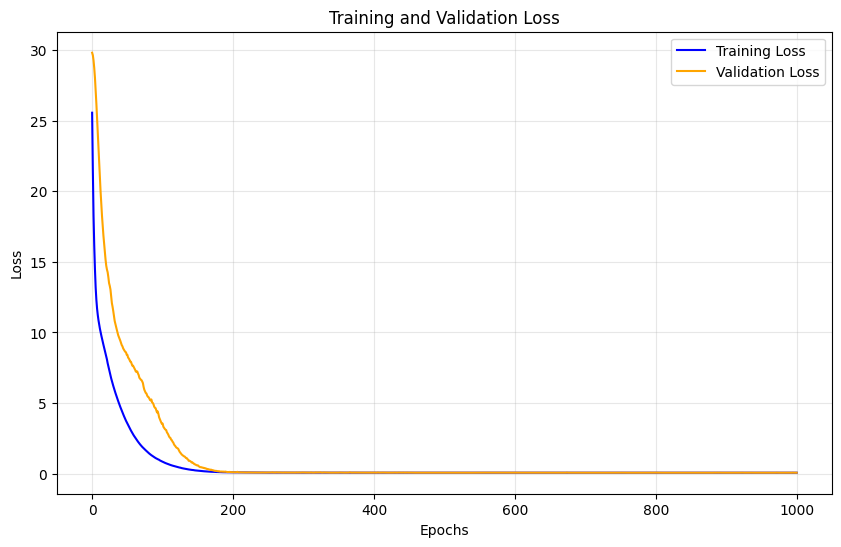

In [26]:
plot_loss(history)

In [27]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

# Prediction & Performance

In [70]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/modified/pm25/final_model-530-0.07')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/related_nitrate_PM25_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :68], ctrl_data[:, 68]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 13ms/step


In [71]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [72]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

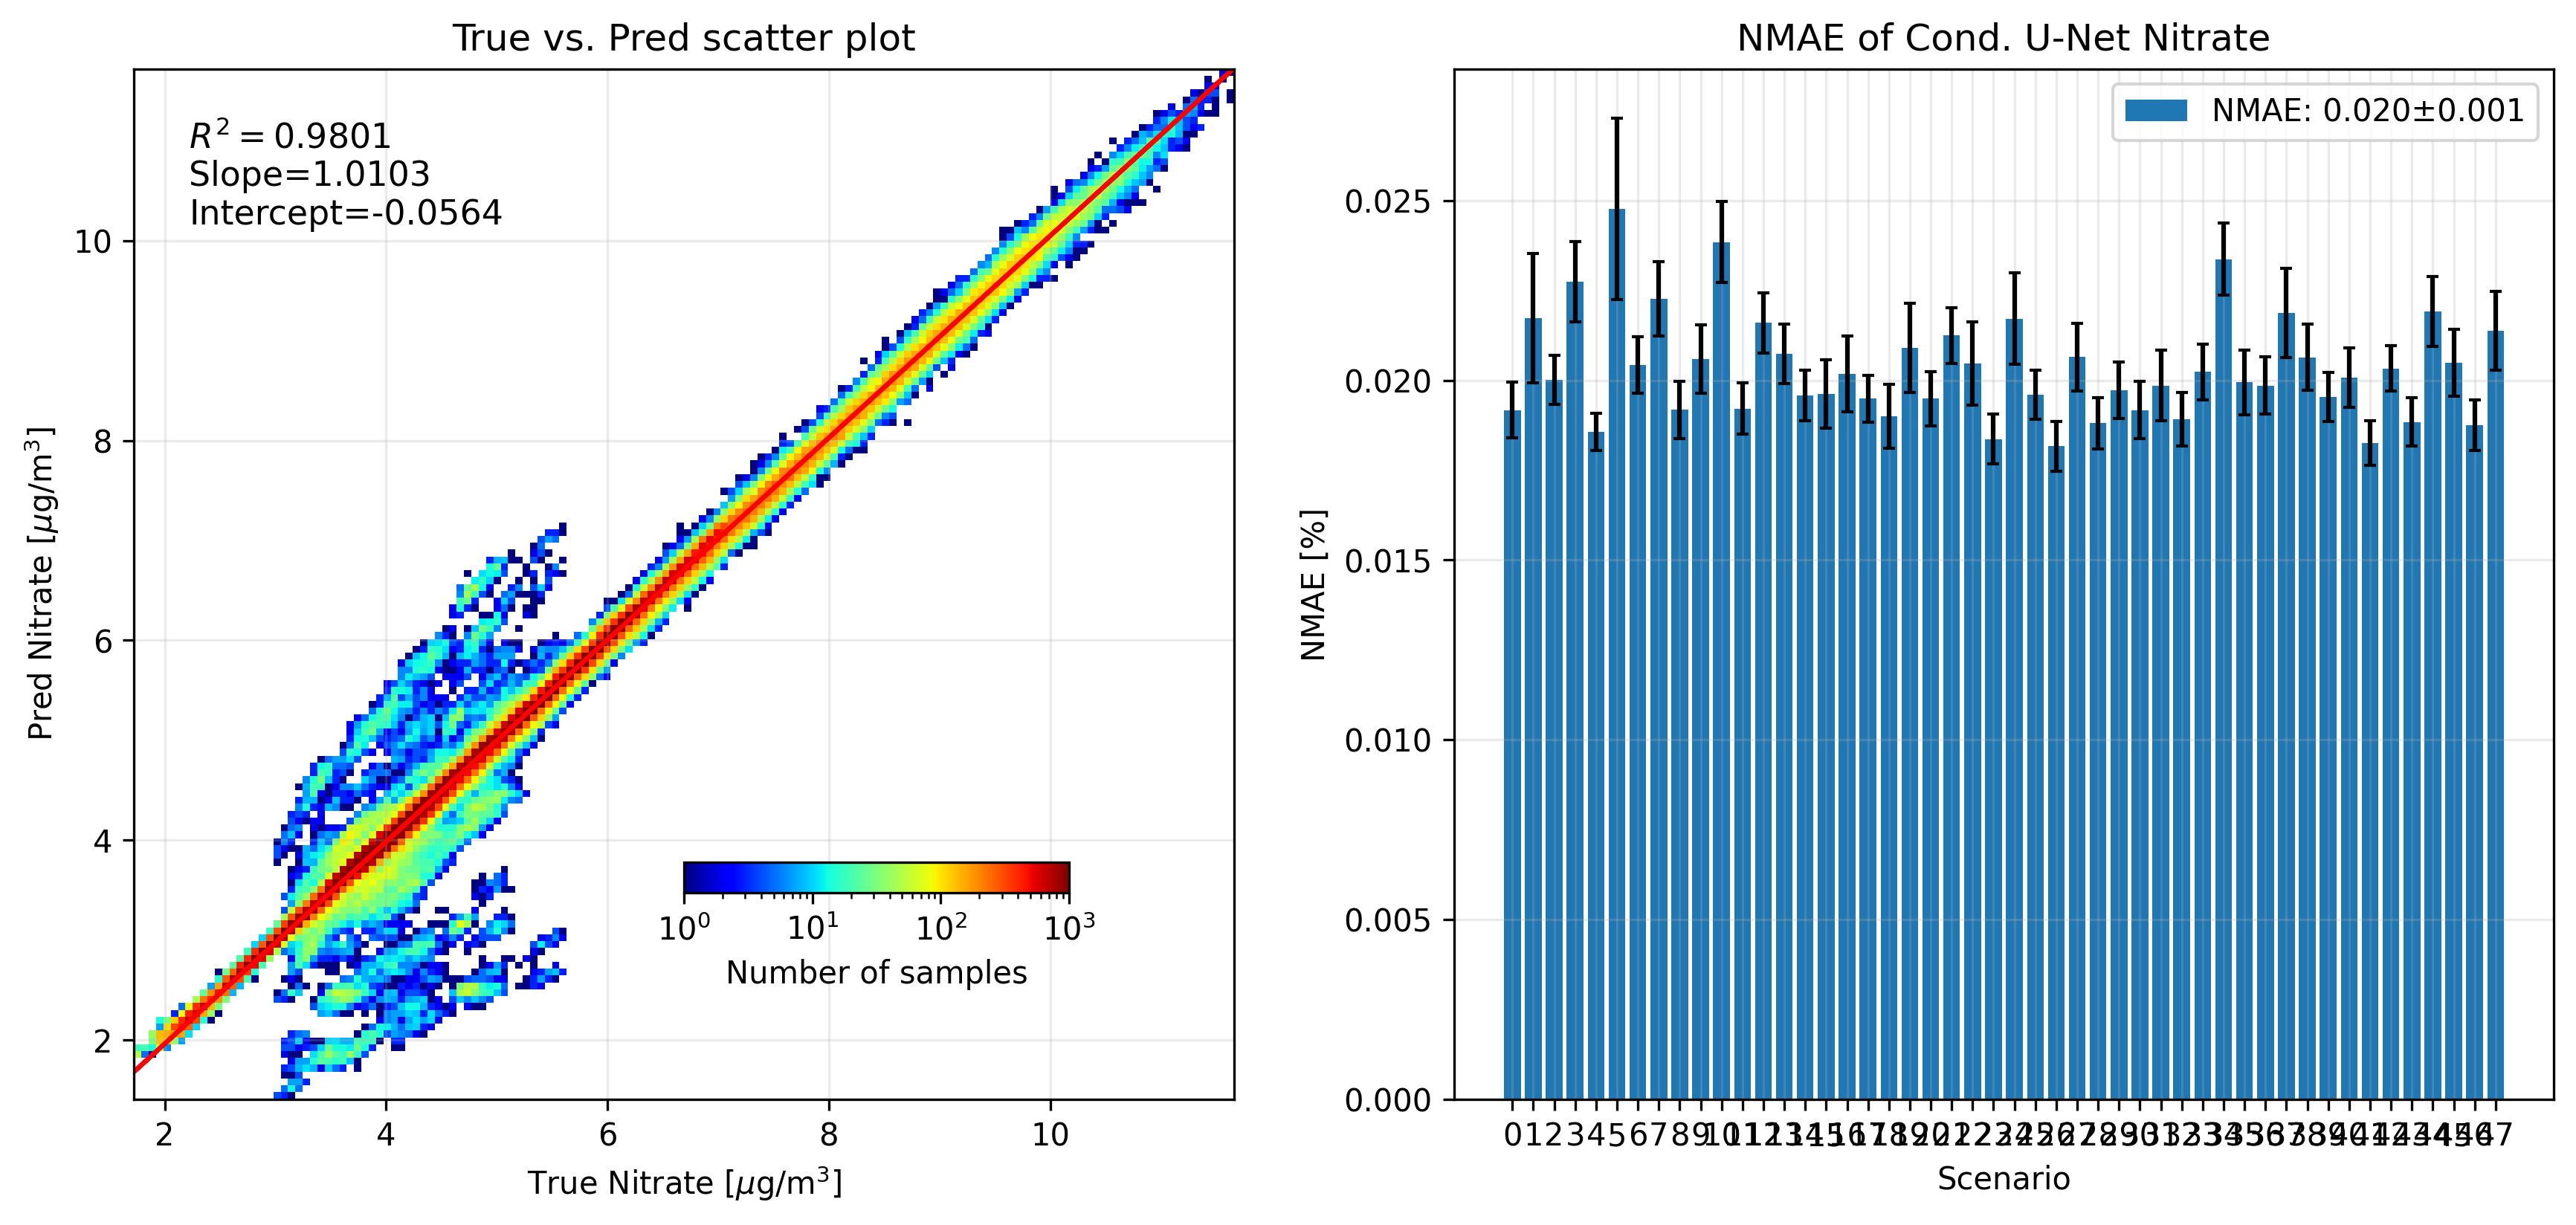

In [73]:
y_pred_ori = y_pred.reshape(-1)
y_true_ori = y_true.reshape(-1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_ori, y_pred_ori)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_ori = y_test.reshape(y_test.shape[0], -1)
y_pred_ori = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Nitrate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')
plt.show()

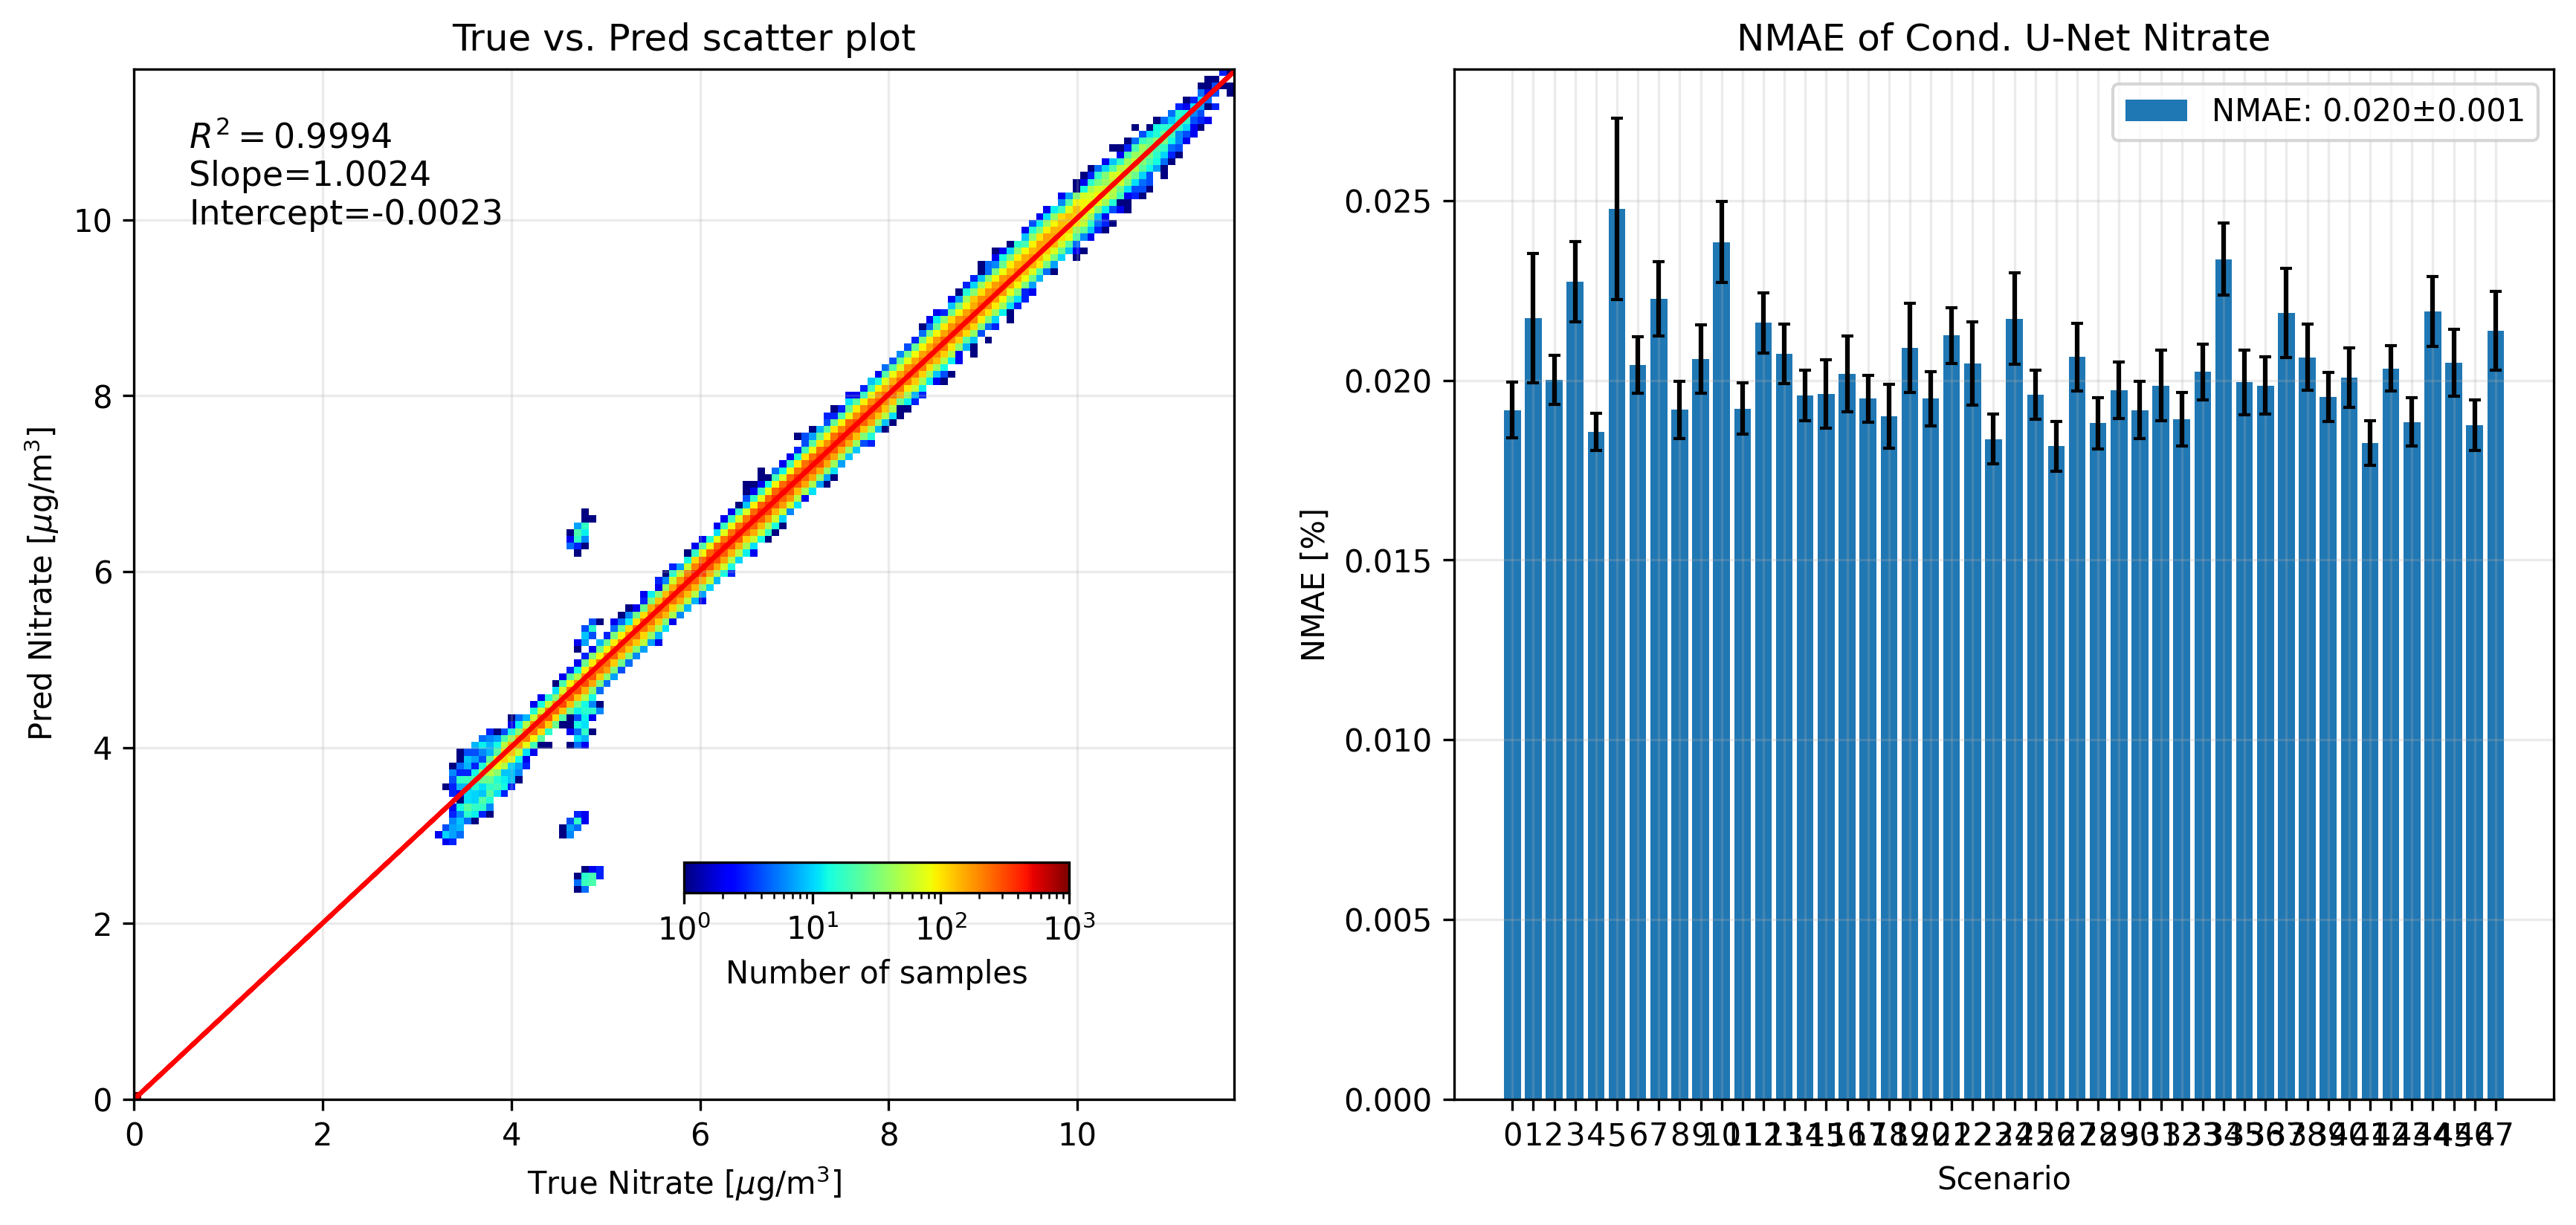

In [74]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
# axes[0].set_xlim(3, 67)  # True 축 범위를 조정
# axes[0].set_ylim(3, 69)  # Pred 축 범위를 조정
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_modi = y_test.reshape(y_test.shape[0], -1)
y_pred_modi = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true_modi, y_pred_modi)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Nitrate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

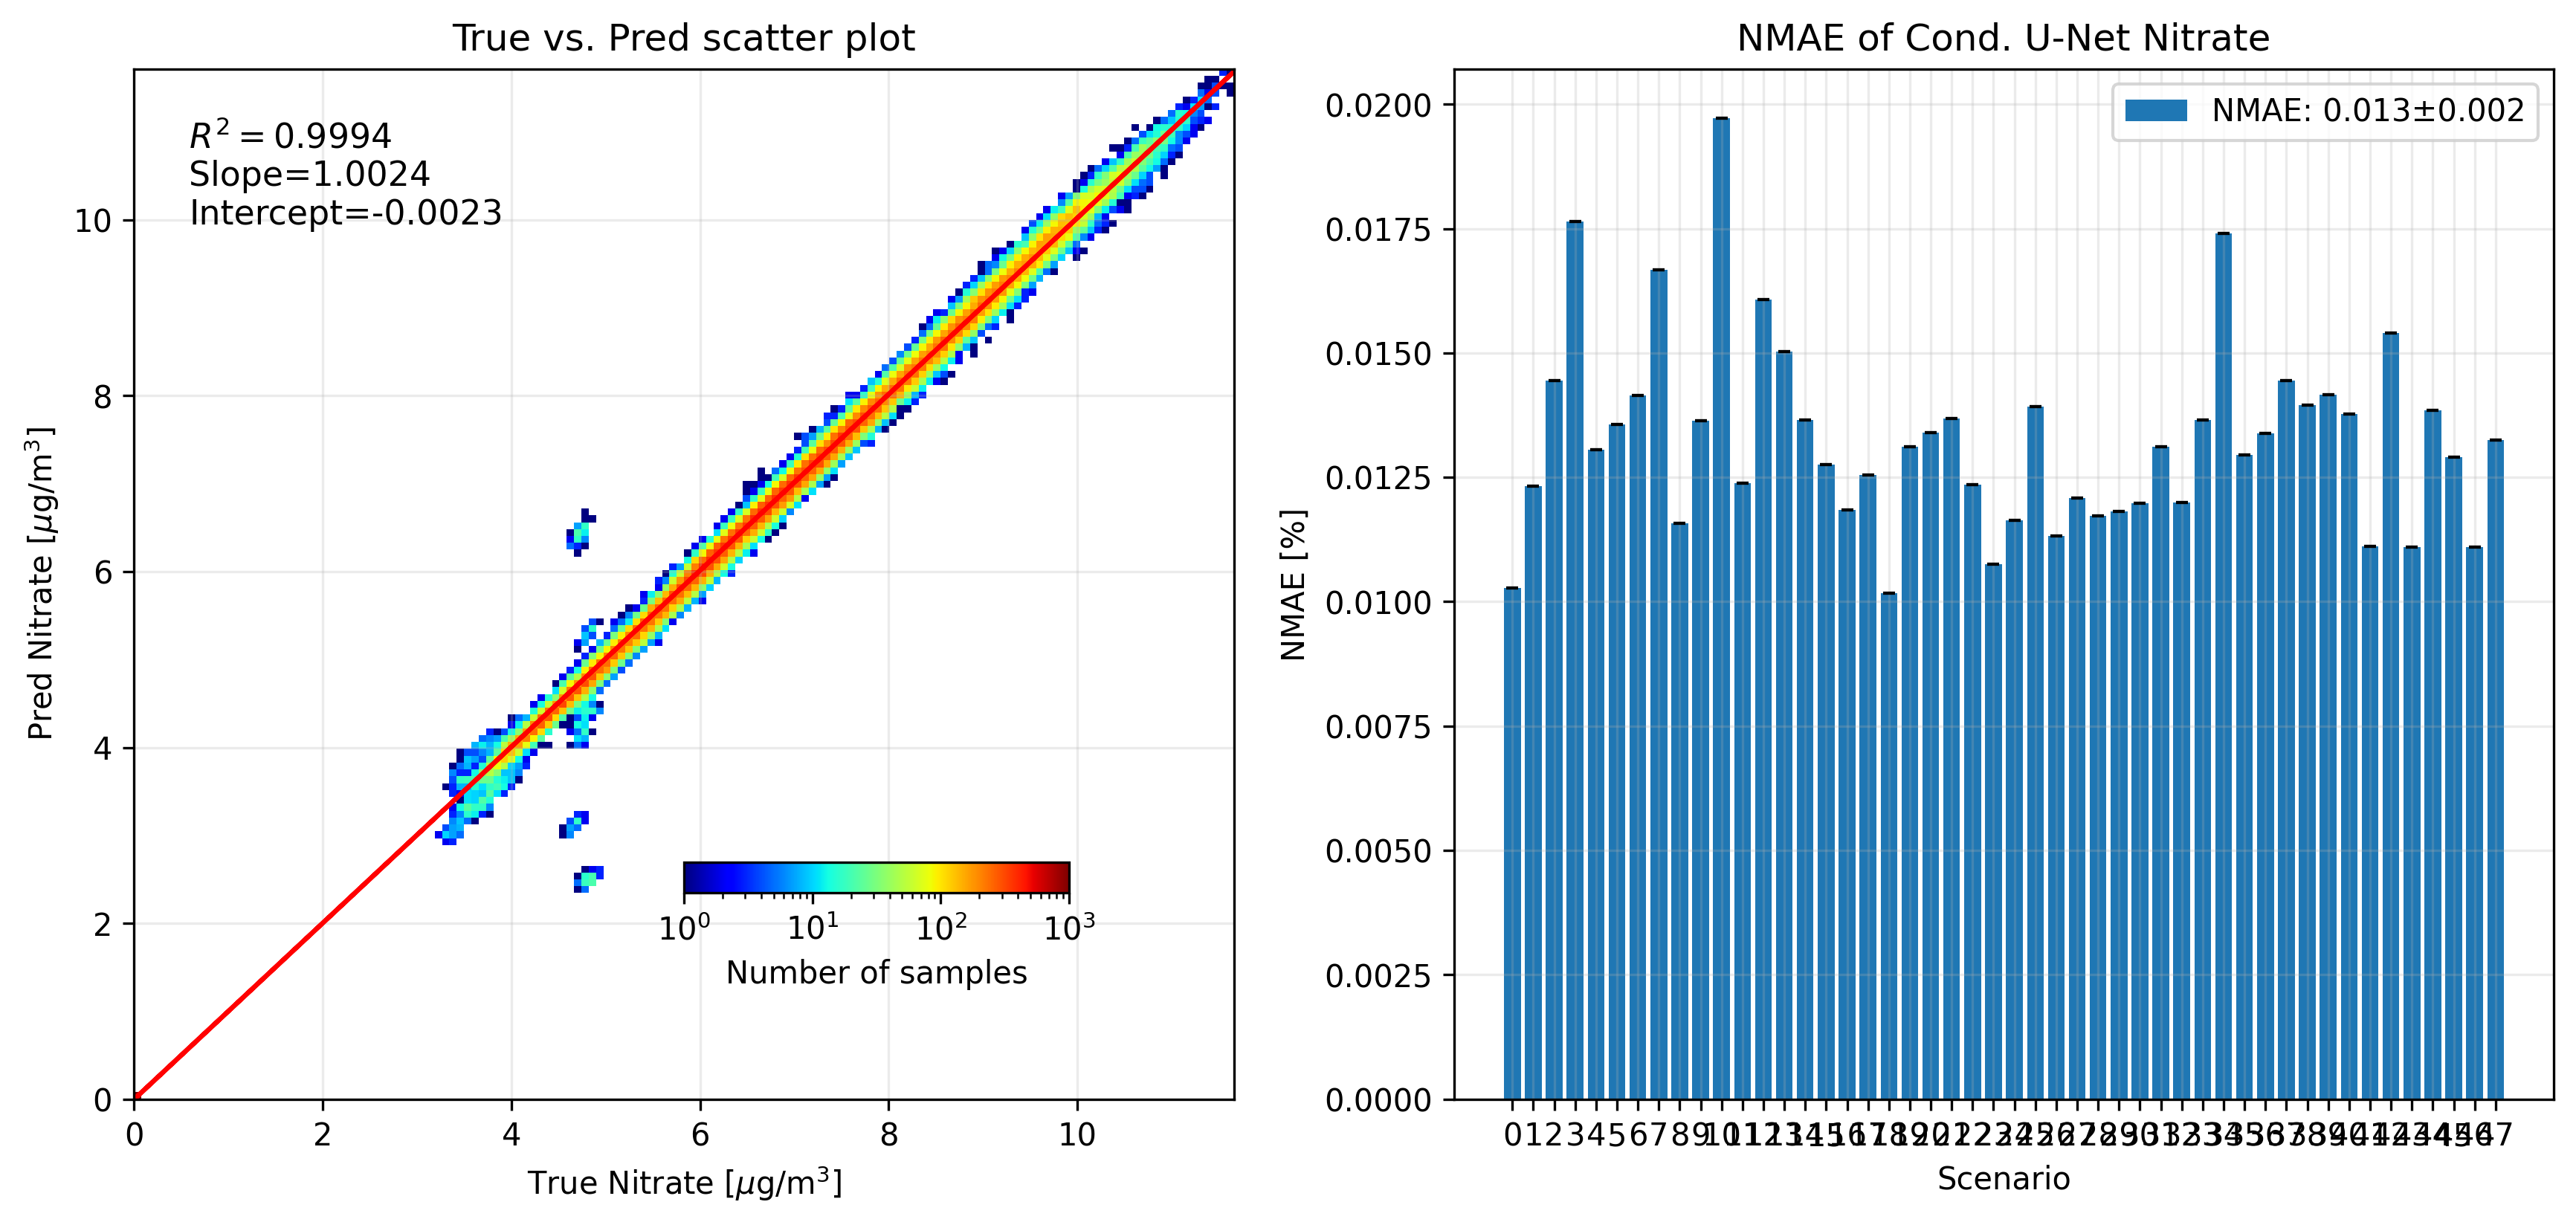

In [75]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Nitrate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

In [76]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


[40]


/tmp/ipykernel_1466185/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1466185/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1466185/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1466185/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1466185/3432564490.py:62: UserWarning: set_ti

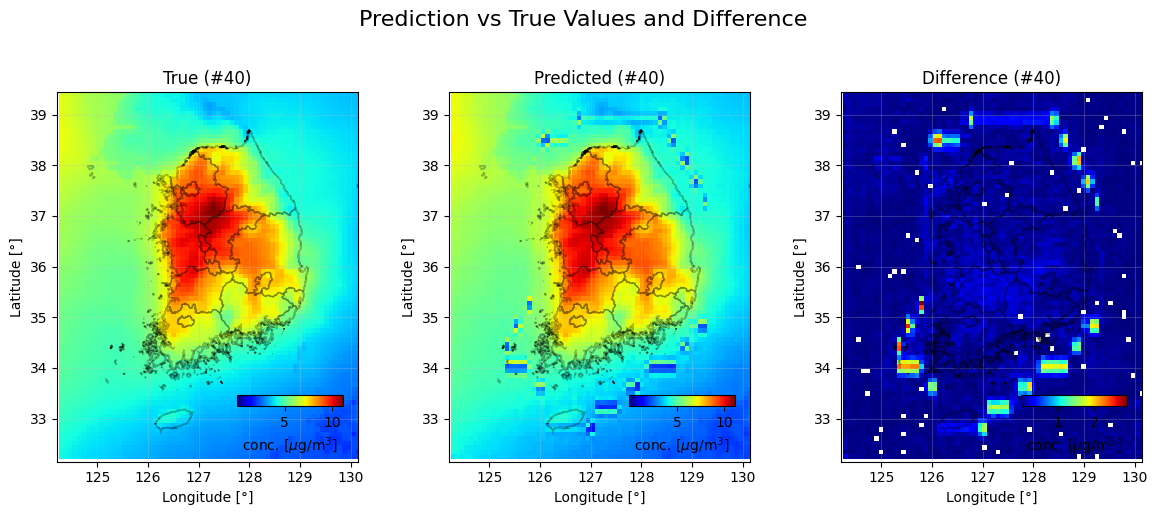

[6]


/tmp/ipykernel_1466185/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1466185/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1466185/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1466185/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1466185/3432564490.py:62: UserWarning: set_ti

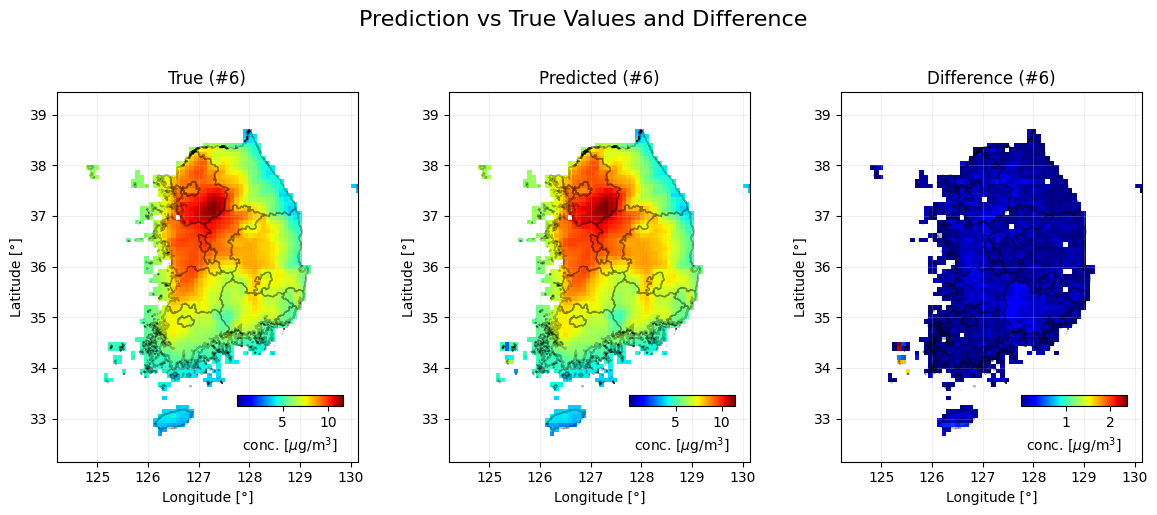

In [77]:
def plot_prediction_loss(y_true, y_pred, num_samples=1):
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(y_true, y_pred)
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines)

In [78]:
tf.keras.backend.clear_session()